In [1]:
import numpy as np
import pandas as pd
from nltk import FreqDist
from nltk.tokenize import \
    regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import re
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_colwidth = 100
seed = 6622

c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\zshoo\anaconda3\envs\learn-env\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_csv('./data/disaster_tweets/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
df.sample(15)

,id,keyword,location,text,target
4003,5686,floods,Cameroon,Bamenda Floods Kill Animals Birds - http://t.co/WnamtxlfMt http://t.co/6cOIDv11qV,1
226,321,annihilated,the own zone layer,day 1 of tryouts went good minus the fact I stopped quickly to get a short ball and Annihilated ...,0
3831,5450,first%20responders,NaN,@IAFFLocal4416 no lives lost except those of first responders or the public they're charged with...,1
6027,8613,seismic,NaN,SEISMIC AUDIO SA-15T SA15T Padded Black Speaker COVERS (2) - Qty of 1 = 1 Pair! http://t.co/2jbI...,0
5652,8064,rescue,"Toronto, Ontario",UD: Rescue (Structural Collapse) - Scott Road @ Ypres Road York (14 Trucks),1
6895,9884,traumatised,North East / Middlesbrough,Sending a snapchat to the wrong person instead of your brother about the toilet ?? ?? ???? #snap...,0
4649,6610,inundated,NYC&NJ,@allyinwondrland That sounds like the perfect bread! I'll hit up Trader Joes this wknd ??. Not r...,0
6935,9945,trouble,North Carolina,@TJ_Robertson2 no bc we always got in trouble for laughing too much ??,0
1216,1754,buildings%20burning,Selma2Oakland,People are more worried about the burning of buildings than black people losing their lives disg...,1
6234,8902,snowstorm,"South, USA",Sassy city girl country hunk stranded in Smoky Mountain snowstorm #AoMS http://t.co/nkKcTttsD9 #...,1


In [5]:
df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
tweets = df.drop(columns=['target'])
target = df['target']

In [7]:
target.value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    tweets, target, test_size=.25, random_state=seed
    )

In [9]:
X_train_tweets_unprocessed = X_train.copy()['text']

X_train['text'] = X_train['text'].str.lower()

In [10]:
token_pattern = r"\b\w+'?’?\w+\b" 
# pattern: Words with at least two letters, including words with up to one hyphen and one apostrophe

tokenizer = RegexpTokenizer(token_pattern)
# Sample:
X_train_sample = X_train.sample(5, random_state=seed)['text']
for tweet in X_train_sample:
    print(tweet)
    print(tokenizer.tokenize(tweet))
    print()

lets collide untill we fill the space.. ??
['lets', 'collide', 'untill', 'we', 'fill', 'the', 'space']

70 years after atomic bombs japan still struggles with war past: the anniversary of the devastation wrought b... http://t.co/1erd2fpryp
['70', 'years', 'after', 'atomic', 'bombs', 'japan', 'still', 'struggles', 'with', 'war', 'past', 'the', 'anniversary', 'of', 'the', 'devastation', 'wrought', 'http', 'co', '1erd2fpryp']

[reuters] debris confirmed from mh370; relatives hope for discovery of crash site http://t.co/dfyasvj7nf
['reuters', 'debris', 'confirmed', 'from', 'mh370', 'relatives', 'hope', 'for', 'discovery', 'of', 'crash', 'site', 'http', 'co', 'dfyasvj7nf']

#worldnews
 video: 'we're picking up bodies from water' - bbc news - home:
rescuers are searching for hundreds of.. http://t.co/6hhmbdk9yo
['worldnews', 'video', "we're", 'picking', 'up', 'bodies', 'from', 'water', 'bbc', 'news', 'home', 'rescuers', 'are', 'searching', 'for', 'hundreds', 'of', 'http', 'co', '6hhmbdk9yo']

In [11]:
# Record if tweet contained a URL, then remove URLs from all tweets

In [12]:
def binary_search_url(text):
    search = re.search(pattern=r'http\S+', string=text)
    return int(bool(search))

X_train['had_url'] = X_train['text'].apply(lambda x: binary_search_url(x))

X_train.sample(5)

,id,keyword,location,text,had_url
6721,9629,thunderstorm,"Oklahoma City, OK",severe thunderstorm warnings have been cancelled in central oklahoma. still expect 50 mph winds ...,0
6433,9206,suicide%20bombing,NaN,suicide bombing is just the fear of dying alone,0
7138,10224,volcano,NaN,@mrmikeeaton @muazimus_prime hill hill mountain volcano of hell mountain hill hil.,0
6684,9577,thunder,NaN,the one thing i like about here is thunder .. heheh,0
4807,6843,loud%20bang,English Midlands,st steel coffee cafetiere exploded this am with loud bang hot coffee &amp; grounds shot over tab...,0


In [13]:
X_train['text'] = X_train['text'].apply(
    lambda x: re.sub(pattern=r'http\S+', repl='', string=x)
    )

In [14]:
# Now we can tokenize

In [15]:
X_train['text_tokenized'] = X_train['text'].apply(tokenizer.tokenize)
X_train.head()

,id,keyword,location,text,had_url,text_tokenized
5372,7668,panic,"Topeka, KS",the good thing is that the #royals won't face a newbie in the playoffs. no real reason to panic.,0,"[the, good, thing, is, that, the, royals, won't, face, newbie, in, the, playoffs, no, real, reas..."
1707,2463,collided,NaN,i scored 111020 points in punch quest stopped when a squeaky bat collided into my skull.,1,"[scored, 111020, points, in, punch, quest, stopped, when, squeaky, bat, collided, into, my, skull]"
4100,5827,hail,"Bay Area, CA",kevin tan says hail to the chefs - û_ and green pastures which features sustainable and organic...,1,"[kevin, tan, says, hail, to, the, chefs, û_, and, green, pastures, which, features, sustainable,..."
4394,6246,hijacking,China,#hot funtenna: hijacking computers to send data as sound waves [black hat 2015] #prebreak #best,1,"[hot, funtenna, hijacking, computers, to, send, data, as, sound, waves, black, hat, 2015, prebre..."
5728,8175,rescuers,NaN,rescuers are searching for hundreds of migrants in the mediterranean after a boat carrying as ma...,0,"[rescuers, are, searching, for, hundreds, of, migrants, in, the, mediterranean, after, boat, car..."


In [16]:
# Frequency Distribution

In [17]:
train_freq_dist = FreqDist(X_train['text_tokenized'].explode())

In [18]:
def plot_top_words(freqdist: FreqDist, title: str='', cutoff: int=10):
    top_10 = freqdist.most_common(cutoff)
    tokens = [w[0] for w in top_10][::-1]
    freqs = [w[1] for w in top_10][::-1]
    fig, ax = plt.subplots()
    ax.barh(tokens, freqs)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel('Word/Token')
    plt.show()

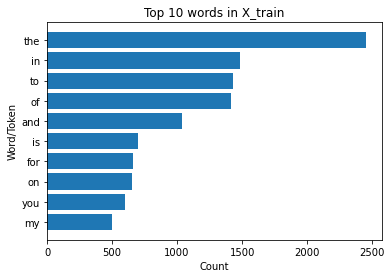

In [19]:
plot_top_words(train_freq_dist, title='Top 10 words in X_train', cutoff=10)

In [20]:
# Getting to a baseline model

In [21]:
tfidf = TfidfVectorizer(max_features=10, token_pattern=token_pattern)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names_out(), index=X_train.index)

,and,for,in,is,my,of,on,the,to,you
5372,0.000000,0.000000,0.306181,0.397235,0.000000,0.000000,0.000000,0.805986,0.314396,0.000000
1707,0.000000,0.000000,0.569644,0.000000,0.821892,0.000000,0.000000,0.000000,0.000000,0.000000
4100,0.860797,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.330637,0.386921,0.000000
4394,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
5728,0.000000,0.414684,0.317121,0.000000,0.000000,0.646339,0.000000,0.556523,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2574,0.752392,0.000000,0.658715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.832826,0.553535,0.000000,0.000000
6069,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6062,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [22]:
baseline_model = MultinomialNB()
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)

In [23]:
baseline_cv

array([0.62872154, 0.61558669, 0.62084063, 0.62609457, 0.60999124])

In [24]:
y_train.value_counts(normalize=True)

0    0.569802
1    0.430198
Name: target, dtype: float64

In [25]:
# Not great. Remove stopwords and potentially include more words